# Hubbard atom single-particle Green's function

From first order Inch worm diagram comparing with KeldyshED reference result.

In [1]:
using Test

using LinearAlgebra: Diagonal, tr

using Keldysh; kd = Keldysh;
using KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

using QInchworm.ppgf: atomic_ppgf, operator_product
using QInchworm.ppgf: total_density_operator, operator_matrix_representation
using QInchworm.ppgf: first_order_spgf
using QInchworm.ppgf: check_ppgf_real_time_symmetries
using QInchworm.ppgf: set_ppgf_symmetric

┌ Info: Precompiling KeldyshED [675b6b9c-7c2f-11e9-3bf3-dfd4d61640f7]
└ @ Base loading.jl:1278
┌ Warning: Package KeldyshED does not have Keldysh in its dependencies:
│ - If you have KeldyshED checked out for development and have
│   added Keldysh as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with KeldyshED
└ Loading Keldysh into KeldyshED from project dependency, future warnings for KeldyshED are suppressed.
┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1278
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QIn

In [2]:
β = 10.

U = +1.0   # Local interaction
V = -0.1  # Hybridization
Bz = +0.025 # Magnetic field
μ = +0.05   # Chemical potential

# Hubbard-atom Hamiltonian

H = U * (op.n("up") - 1/2) * (op.n("do") - 1/2) 
H += V * (op.c_dag("up") * op.c("do") + op.c_dag("do") * op.c("up")) 
H += Bz * (op.n("up") - op.n("do"))
H += μ * (op.n("up") + op.n("do"))

#H = 0. * op.n("up") + 0. * op.n("do")

# Exact Diagonalization solver

soi = ked.Hilbert.SetOfIndices([["up"], ["do"]]);
#soi = ked.Hilbert.SetOfIndices([["up"]]);
ed = ked.EDCore(H, soi)
ρ = ked.density_matrix(ed, β)
    
# Real-time Kadanoff-Baym contour
contour = kd.twist(kd.Contour(kd.full_contour, tmax=7., β=β));
grid = kd.TimeGrid(contour, npts_real=10, npts_imag=20);
    
# Single particle Green's function
u = ked.Hilbert.IndicesType(["up"])
d = ked.Hilbert.IndicesType(["do"])
    
G0 = atomic_ppgf(grid, ed, β);

g = first_order_spgf(G0, ed, u, u);
g_ref = ked.computegf(ed, grid, [(u, u)], β)[1];
@test isapprox(g, g_ref, atol=1e-12, rtol=1-12)

Test Passed

# Visualization

In [3]:
using PyCall; PyCall.pygui(:tk);
using PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

extent = nothing
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>-1., :vmax=>1., :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hugstr/.julia/packages/PyPlot/XHEG0/src/init.jl:192


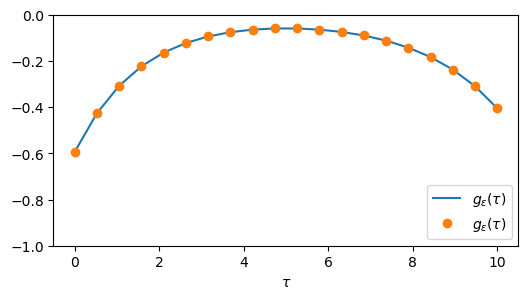

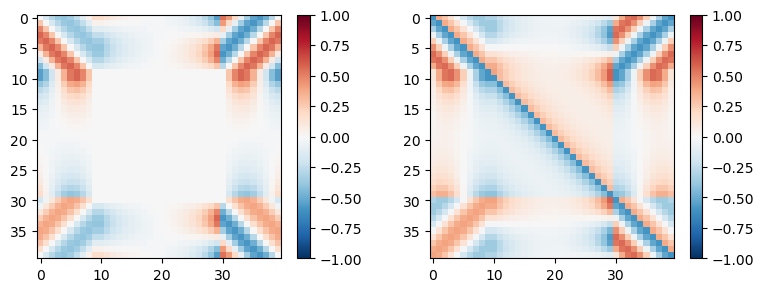

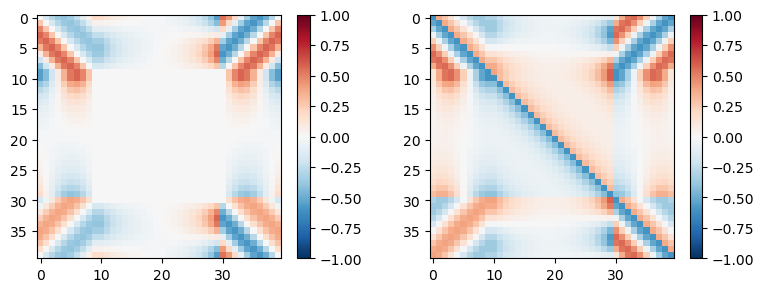

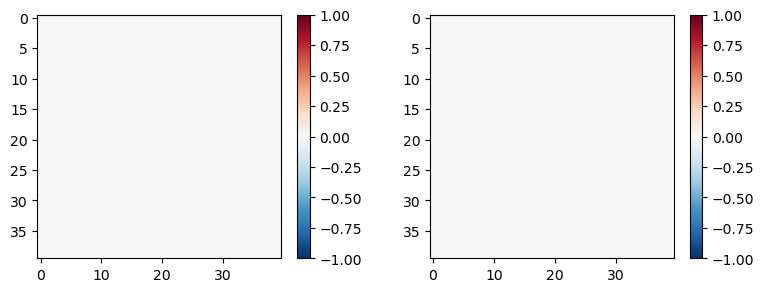

Dimension of full Hilbert space: 4
Number of invariant subspaces: 3
  Subspace 1, dim = 2
    Basis Fock states: UInt64[0x0000000000000001, 0x0000000000000002]
    Energy levels: [0.0, 0.206155281280883]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [0.5530776406404415]
  Subspace 3, dim = 1
    Basis Fock states: UInt64[0x0000000000000003]
    Energy levels: [0.6530776406404415]
Ground state energy: -0.3030776406404415


In [4]:
τ = kd.imagtimes(grid)
plt.figure(figsize=(6, 3))
plt.plot(τ, g[:matsubara], label=plt.L"$g_\varepsilon(\tau)$")
plt.plot(τ, g_ref[:matsubara], "o", label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0]);

plot2d(g.data)
plot2d(g_ref.data)
plot2d(g.data - g_ref.data)
ed

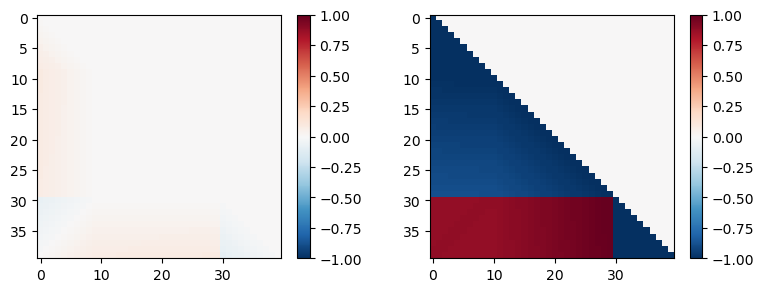

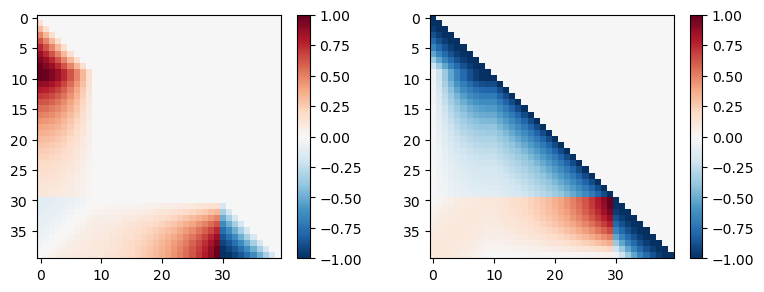

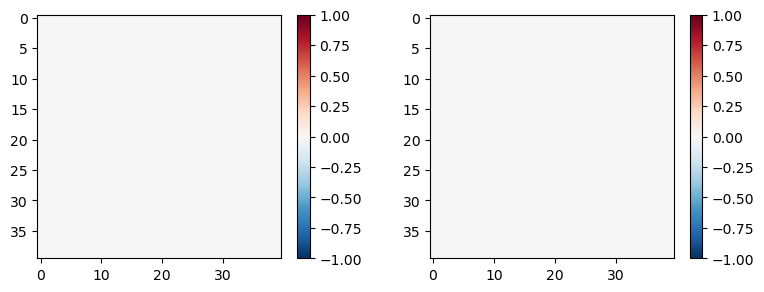

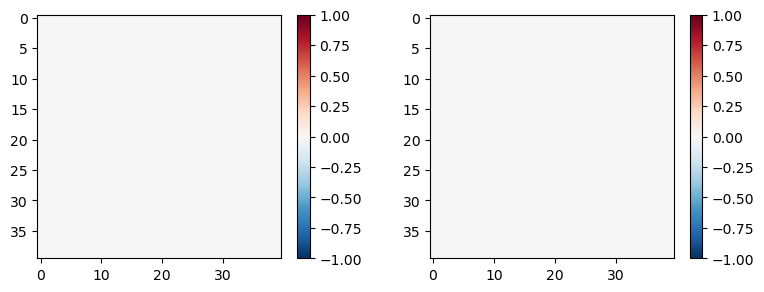

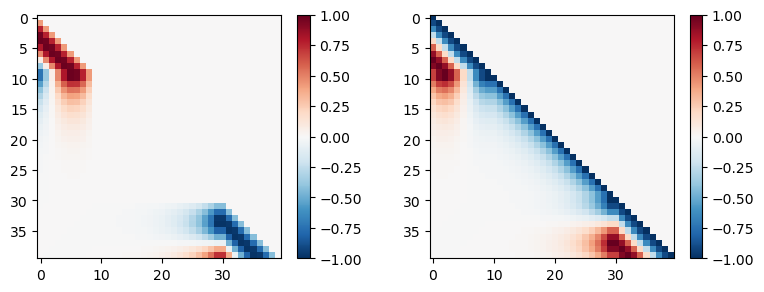

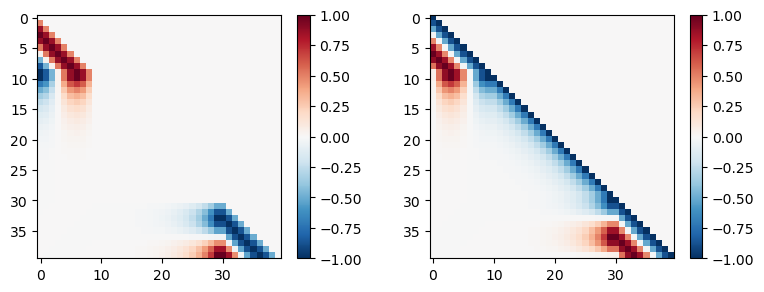

In [5]:
plot2d(G0[1].data[1, 1, :, :])
plot2d(G0[1].data[2, 2, :, :])
plot2d(G0[1].data[1, 2, :, :])
plot2d(G0[1].data[2, 1, :, :])
plot2d(G0[2].data[1, 1, :, :])
plot2d(G0[3].data[1, 1, :, :])

# ppgf symmetries

Note that, since the order of the times on the backwards branch is from $t_{max}$ to $0$, the ppgf $\hat{G}_{--}(t_{-}, t_{-}')$ on the "lower diagonal" in "twisted contour time index space" corresponds to the time order $t_{-} \le t_{-}'$.

For the forward branch on the other hand the order of times is $0$ to $t_{max}$ and the ppgf $\hat{G}_{++}(t_{+}, t_{+}')$ on the lower diagonal corresponds to $t_{+} \ge t_{+}'$.

$$
\hat{G}_{--}(t, t') = - [ \hat{G}_{++}(t', t)]^\dagger 
$$

$$
\hat{G}_{M-}(\tau, t') = -\xi [ \hat{G}_{+M}(t', \tau) ]^\dagger
$$

$$
\hat{G}_{+-}(t, t') = -[ \hat{G}_{+-}(t', t') ]^\dagger
$$

In [7]:
function inch_times(grid)
    times = Vector{Tuple{kd.TimeGridPoint, kd.TimeGridPoint}}()
    for z in grid[kd.backward_branch][end:-1:1]
        for zb in grid[kd.backward_branch][end:-1:z.idx]
            push!(times, (zb, z))
        end
        for τ in grid[kd.imaginary_branch]
            push!(times, (τ, z))
        end
        fwd_idx = grid[kd.backward_branch][end].idx - z.idx + 1
        for zf in grid[kd.forward_branch][1:fwd_idx]
            push!(times, (zf, z))
        end
    end
    times
end

N_op = total_density_operator(ed)
N = operator_matrix_representation(N_op, ed)

for (idx, (z1, z2)) in enumerate(inch_times(grid))
    for (sidx, g_s) in enumerate(G0)
        n = N[sidx]
        val = g_s[z1, z2]
        set_ppgf_symmetric(g_s, n, z1, z2, val)
    end
end

@test check_ppgf_real_time_symmetries(G0, ed)

Test Passed